# Quadratic Hamiltonians and Slater determinants

This notebook uses the following pull request: https://github.com/Qiskit/qiskit-nature/pull/483.

A quadratic Hamiltonian is a Hamiltonian of the form
$$
    H =
    \sum_{j, k} M_{jk} a^\dagger_j a_k
    + \frac12 \sum_{j, k}
        (\Delta_{jk} a^\dagger_j a^\dagger_k + \Delta^*_{jk} a_k a_j)
    + \text{constant}
$$
where $M$ is a Hermitian matrix ($M^\dagger = M$) and $\Delta$ is an antisymmetric matrix ($\Delta^T = -\Delta$), and the $\{a_j\}$ are fermionic annihilation operators which satisfy the anticommutation relations
$$
    \begin{align}
        a_j a_k + a_k a_j &= 0 \\
        a_j a^\dagger_k + a^\dagger_k a_j &= \delta_{pq}
    \end{align}.
$$

Quadratic Hamiltonians are an important class of Hamiltonians that are classically tractable. Their eigenstates are called fermionic Gaussian states, and they can be efficiently be prepared on a quantum computer.

Of course, the `FermionicOp` class can be used to represent any quadratic Hamiltonian. The reason to create a class specifically for quadratic Hamiltonians is that they support special numerical routines that involve performing linear algebra on the matrices $M$ and $\Delta$. The internal representation format of `FermionicOp` is not suitable for these routines.

A quadratic Hamiltonian is initialized using `QuadraticHamiltonian`.

In [1]:
import numpy as np
from qiskit_nature.operators.second_quantization import QuadraticHamiltonian

# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
antisymmetric_part = np.array(
    [
        [0.0, 3.0, 0.0, 0.0],
        [-3.0, 0.0, 3.0, 0.0],
        [0.0, -3.0, 0.0, 3.0],
        [0.0, 0.0, -3.0, 0.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    antisymmetric_part=antisymmetric_part,
    constant=constant,
)

# convert it to a FermionicOp and print it
hamiltonian_ferm = hamiltonian.to_fermionic_op()
hamiltonian_ferm.display_format = "sparse"
hamiltonian_ferm.set_truncation(0)
print(hamiltonian_ferm)

Fermionic Operator
register length=4, number terms=29
  4.0
+ 1.0 * ( +_0 -_0 )
+ 2.0 * ( +_0 -_1 )
+ 2.0 * ( +_1 -_0 )
+ 3.0 * ( +_0 +_1 )
+ 3.0 * ( -_1 -_0 )
+ 0.0 * ( +_0 -_2 )
+ 0.0 * ( +_2 -_0 )
+ 0.0 * ( +_0 +_2 )
+ 0.0 * ( -_2 -_0 )
+ 0.0 * ( +_0 -_3 )
+ 0.0 * ( +_3 -_0 )
+ 0.0 * ( +_0 +_3 )
+ 0.0 * ( -_3 -_0 )
+ 1.0 * ( +_1 -_1 )
+ 2.0 * ( +_1 -_2 )
+ 2.0 * ( +_2 -_1 )
+ 3.0 * ( +_1 +_2 )
+ 3.0 * ( -_2 -_1 )
+ 0.0 * ( +_1 -_3 )
+ 0.0 * ( +_3 -_1 )
+ 0.0 * ( +_1 +_3 )
+ 0.0 * ( -_3 -_1 )
+ 1.0 * ( +_2 -_2 )
+ 2.0 * ( +_2 -_3 )
+ 2.0 * ( +_3 -_2 )
+ 3.0 * ( +_2 +_3 )
+ 3.0 * ( -_3 -_2 )
+ 1.0 * ( +_3 -_3 )


/home/kevinsung/projects/qiskit-nature/qiskit_nature/operators/second_quantization/quadratic_hamiltonian.py:148: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(terms, register_length=self._num_modes)


## Diagonalization and state preparation
A quadratic Hamiltonian can always be rewritten in the form
$$
    H = \sum_{j} \varepsilon_j b^\dagger_j b_j + \text{constant}
$$
where $\varepsilon_0 \leq \varepsilon_1 \leq \cdots \leq \varepsilon_N$ are non-negative real numbers and
the $\{b_j^\dagger\}$ are a new set of fermionic creation operators
that also satisfy the canonical anticommutation relations.
These new creation operators are linear combinations of the original creation and annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    a_1 \\
    \vdots \\
    a_N
    \end{pmatrix},
$$
where $W$ is an $N \times 2N$ matrix. Given a basis of eigenvectors of the Hamiltonian, each eigenvector is labeled by a subset of $\{0, \ldots, N - 1\}$, which we call the occupied orbitals. The corresponding eigenvalue is the sum of the corresponding values of $\varepsilon_j$, plus the constant.

The transformation matrix $W$ is used to construct a circuit to prepare an eigenvector of the Hamiltonian. The circuit is constructed using the `FermionicGaussianState` class. This circuit assumes the Jordan-Wigner Transform is used. The circuit has linear depth and uses only linear qubit connectivity. The algorithm is from https://arxiv.org/abs/1711.05395.

In [2]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print("Shape of matrix W:")
print(transformation_matrix.shape)
print()
print("Orbital energies:")
print(orbital_energies)
print()
print("Transformed constant:")
print(transformed_constant)

Shape of matrix W:
(4, 8)

Orbital energies:
[0.29826763 4.38883678 5.5513683  5.64193745]

Transformed constant:
-1.9402050758492795


Eigenvalue:
3.909430851761581


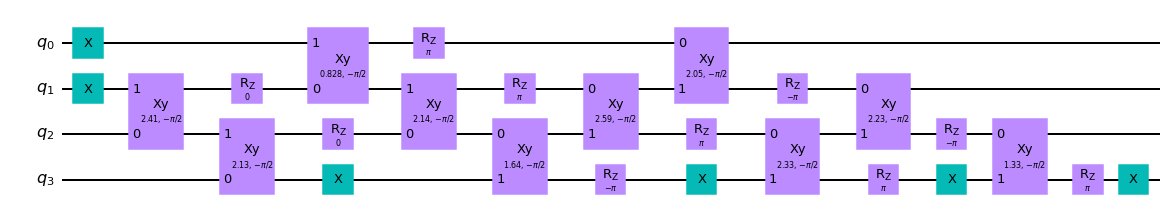

In [3]:
from qiskit_nature.circuit.library import FermionicGaussianState

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print("Eigenvalue:")
print(eig)

circuit = FermionicGaussianState(
    transformation_matrix, occupied_orbitals=occupied_orbitals
)
circuit.draw("mpl")

In [4]:
from qiskit.quantum_info import Statevector
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

# simulate the circuit to get the final state
state = np.array(Statevector(circuit))

# convert the Hamiltonian to a matrix
hamiltonian_jw = JordanWignerMapper().map(hamiltonian_ferm).to_matrix()

# check that the state is an eigenvector with the expected eigenvalue
np.testing.assert_allclose(hamiltonian_jw @ state, eig * state, atol=1e-8)

## Slater determinants

When the antisymmetric part $\Delta = 0$, then the Hamiltonian conserves particle number. In this case, the basis change only needs to mix creation operators, not annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    \end{pmatrix},
$$
where now $W$ is an $N \times N$ matrix. Furthermore, the $\{\varepsilon_j\}$ are allowed to be negative.

In [5]:
# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    constant=constant,
)

print("Hamiltonian conserves particle number:")
print(hamiltonian.conserves_particle_number())

Hamiltonian conserves particle number:
True


In [6]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print("Shape of matrix W:")
print(transformation_matrix.shape)
print()
print("Orbital energies:")
print(orbital_energies)
print()
print("Transformed constant:")
print(transformed_constant)

Shape of matrix W:
(4, 4)

Orbital energies:
[-2.23606798 -0.23606798  2.23606798  4.23606798]

Transformed constant:
4.0


In this special case, the eigenstates are called Slater determinants, and a more efficient algorithm is used to prepare them. This algorithm is accessed by using the `SlaterDeterminant` class instead of `FermionicGaussianState`. `SlaterDeterminant` does not take the occupied orbitals as input. Instead, the shape of the transformation matrix is allowed to vary. It should be an $\eta \times N$ matrix where $\eta$ is the number of particles.

Eigenvalue:
4.000000000000001


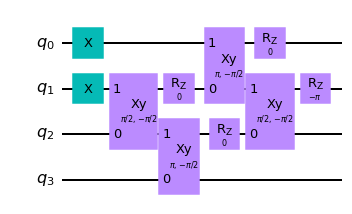

In [7]:
from qiskit_nature.circuit.library import SlaterDeterminant

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print("Eigenvalue:")
print(eig)

circuit = SlaterDeterminant(transformation_matrix[list(occupied_orbitals)])
circuit.draw("mpl")

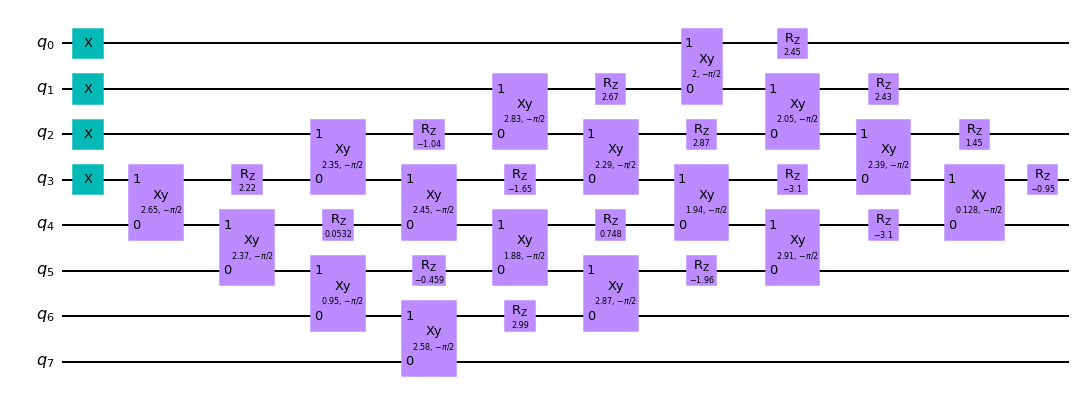

In [8]:
from qiskit.quantum_info import random_hermitian

# construct and display some larger circuits
N = 8
n_particles = 4
hermitian_part = np.array(random_hermitian(N))
hamiltonian = QuadraticHamiltonian(hermitian_part)
transformation_matrix, _, _ = hamiltonian.diagonalizing_bogoliubov_transform()
occupied_orbitals = range(n_particles)
circuit = SlaterDeterminant(transformation_matrix[list(occupied_orbitals)])
circuit.draw("mpl")